https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-santander-value

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [42]:
labeled = pd.read_csv(r'../data/train.csv')
print(labeled.shape)

(4459, 4993)


In [4]:
labeled.columns

Index(['ID', 'target', '48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00',
       '2f0771a37', '30347e683', 'd08d1fbe3', '6ee66e115',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4993)

### Take a look at the Y distribution
- Might want to take log of right-skewed money values (non-neg; log(Y)~normal => good for linear regression)

Text(0.5,1,'Target Histogram')

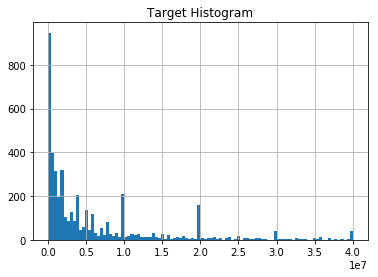

In [5]:
labeled['target'].hist(bins=100)
plt.title("Target Histogram")

Text(0.5,1,'Log Target Histogram')

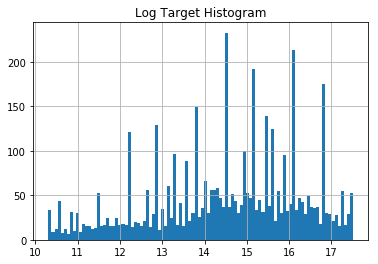

In [6]:
labeled['target'].map(np.log).hist(bins=100)
plt.title('Log Target Histogram')

### Take a look at X
- missing values?
- data types?
- constants?

In [7]:
missing_df = labeled.isnull().sum(axis=0).reset_index()
missing_df.columns=['col','NAs']
missing_df[missing_df.NAs!=0]

,col,NAs


In [8]:
dtype_df = labeled.dtypes.reset_index()
dtype_df.groupby(0).count() # all numeric

,index
0,
int64,3147
float64,1845
object,1


In [9]:
constant_df = labeled.nunique().reset_index()
constant_df.columns = ['col','unique_vals']
len(constant_df[constant_df.unique_vals==1])

256

In [10]:
const_col = list(constant_df[constant_df.unique_vals==1].col.values)
len(const_col)

256

with open(r'../input/drop_cols.txt',"w") as f:
    for col in const_col:
        f.write(col+",")

#### Linear model - correlation of features with log(Y)

In [43]:
labeled.drop(labels=const_col,axis=1,inplace=True)
print(labeled.shape)

(4459, 4737)


In [44]:
labeled['log_target'] = np.log(labeled.target)

In [47]:
print(labeled[['target','48df886f9']].corr().values[0,1])
print(labeled[['log_target','48df886f9']].corr().values[0,1])

0.010188021496986742
0.008004854786918132


In [60]:
%%time
feature_dict={}
for feature in labeled.columns[2:]:
    if feature != 'log_target':    
        feature_dict[feature] = [labeled[['target',feature]].corr().values[0,1],
                                 labeled[['log_target',feature]].corr().values[0,1]]

Wall time: 6.92 s


In [61]:
feat_corr_df = pd.DataFrame.from_dict(feature_dict, orient='index').reset_index()
feat_corr_df.columns = ['feat','corr','corr_log']
feat_corr_df['corr_abs'] = feat_corr_df['corr'].map(np.abs)
feat_corr_df['corr_log_abs'] = feat_corr_df['corr_log'].map(np.abs)

In [62]:
feat_corr_df.sort_values('corr_abs',ascending=False)[:20]

,feat,corr,corr_log,corr_abs,corr_log_abs
4476,555f18bd3,0.273379,0.153014,0.273379,0.153014
2617,9fd594eec,0.270019,0.197227,0.270019,0.197227
2342,5bc7ab64f,0.267858,0.143492,0.267858,0.143492
3337,cbbc9c431,0.265005,0.148933,0.265005,0.148933
4135,f190486d6,0.263821,0.195312,0.263821,0.195312
4707,6b119d8ce,0.258290,0.142460,0.258290,0.142460
4190,f74e8f13d,0.257238,0.172803,0.257238,0.172803
570,ac30af84a,0.256292,0.149509,0.256292,0.149509
537,26fc93eb7,0.255186,0.172284,0.255186,0.172284
2378,58e2e02e6,0.254984,0.187259,0.254984,0.187259


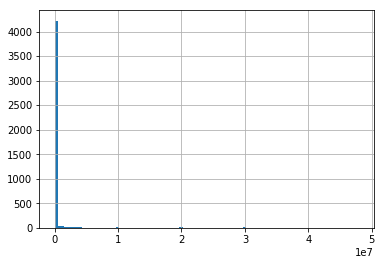

In [63]:
labeled['555f18bd3'].hist(bins=100)

In [64]:
(labeled['555f18bd3']!=0).sum() # ok, very sparse

324

In [36]:
%%time
feature_sparse_dict={}
for feature in labeled.columns[2:]:
    feature_sparse_dict[feature] = (labeled[feature]!=0).sum()

Wall time: 1.08 s


In [65]:
feat_sparse_df = pd.DataFrame.from_dict(feature_sparse_dict,orient='index').reset_index()
feat_sparse_df.columns = ['feat','values']
print(feat_sparse_df['values'].describe())
feat_sparse_df.sort_values('values',ascending=False)[:5]

count    4735.000000
mean      147.858289
std       216.818376
min         1.000000
25%        15.000000
50%        70.000000
75%       180.000000
max      1565.000000
Name: values, dtype: float64


,feat,values
4321,c5a231d81,1565
1953,0ff32eb98,1565
2934,91f701ba2,1560
4513,c47340d97,1555
3816,adb64ff71,1547


In [66]:
feats = pd.merge(feat_corr_df, feat_sparse_df,how='inner',on='feat')
print(feats.shape)
feats[:3]

(4735, 6)


,feat,corr,corr_log,corr_abs,corr_log_abs,values
0,48df886f9,0.010188,0.008005,0.010188,0.008005,39
1,0deb4b6a8,0.013805,-0.000881,0.013805,0.000881,4
2,34b15f335,0.014694,0.025378,0.014694,0.025378,33


In [67]:
feats.to_csv(r'../input/feat_corr_sparse.txt',index=False) # write out for future use

In [68]:
## Take the top non-sparse linear features
feats.sort_values(['values','corr_log_abs'],ascending=[False,False])[:40]

,feat,corr,corr_log,corr_abs,corr_log_abs,values
1953,0ff32eb98,0.191524,0.140245,0.191524,0.140245,1565
4321,c5a231d81,0.191321,0.136049,0.191321,0.136049,1565
2934,91f701ba2,0.206891,0.146636,0.206891,0.146636,1560
4513,c47340d97,0.213456,0.147842,0.213456,0.147842,1555
3816,adb64ff71,0.199026,0.143651,0.199026,0.143651,1547
545,0572565c2,0.201068,0.134714,0.201068,0.134714,1547
4135,f190486d6,0.263821,0.195312,0.263821,0.195312,1544
4033,5c6487af1,0.209962,0.143667,0.209962,0.143667,1539
4346,e176a204a,0.191612,0.144795,0.191612,0.144795,1535
645,6619d81fc,0.200045,0.137863,0.200045,0.137863,1533


In [69]:
top_non_sparse_feat = feats.sort_values(['values','corr_log_abs'],ascending=[False,False])[:40]['feat'].values.tolist()

In [116]:
y = labeled['target']
X = labeled[top_non_sparse_feat]

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)

In [119]:
ln = LinearRegression()
ln.fit(X_train,np.log(y_train))
print(ln.score(X_train,np.log(y_train)))
y_pred = ln.predict(X_val)

0.0948001033023862


In [120]:
y_pred_exp = np.exp(y_pred)

In [121]:
def rmsle(pred, val):
    return(np.sqrt(((np.log(pred+1) - np.log(val+1))**2).mean()))

In [122]:
rmsle(y_pred_exp,y_val)

1.6367696090255288

#### Non-linear feature importance

In [123]:
all_feat = [col for col in labeled.columns if re.search(re.compile("target|ID"),col) is None]
len(all_feat)

4735

In [139]:
X_train2, X_val2, y_train, y_val = train_test_split(labeled[all_feat],y,test_size=0.2,random_state=1)

In [140]:
rf = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=1)
rf.fit(X_train2,np.log(y_train))
y_pred2 = rf.predict(X_val2)
rmsle(np.exp(y_pred2),y_val)

1.5934216833920425

In [141]:
nl_feat = pd.concat([pd.Series(X_train2.columns),pd.Series(rf.feature_importances_)],axis=1).sort_values(by=1,ascending=False)
nl_feat.columns = ['feat','rf_imp_score']

In [142]:
top_nl_feat = nl_feat.feat[:40]

In [143]:
len(set(top_nl_feat) - set(top_non_sparse_feat)) # 21 non-overlapping

21

In [144]:
nl_feat.to_csv(r"../input/nln_feat.txt",index=False)

In [126]:
X_train2, X_val2, y_train, y_val = train_test_split(labeled[top_nl_feat],y,test_size=0.2,random_state=1)

In [127]:
rf = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=1)
rf.fit(X_train2,np.log(y_train))
y_pred2 = rf.predict(X_val2)
rmsle(np.exp(y_pred2),y_val)

1.5939661729391676

### Apply on test

In [77]:
test = pd.read_csv(r'../data/test.csv')
print(test.shape)
test[:3]

(49342, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
pred_target1 = np.exp(ln.predict(test[top_non_sparse_feat]))
pred_target2 = np.exp(rf.predict(test[top_nl_feat]))

In [133]:
output = pd.concat([test['ID'],pd.Series((pred_target1+pred_target2)/2)],axis=1)
output.columns=['ID','target']

In [134]:
output[:3]

,ID,target
0,000137c73,1.611650e+06
1,00021489f,1.595106e+06
2,0004d7953,1.894674e+06


In [136]:
output.to_csv('../output/0808_logY_40ln_40nln_lr+rf.csv',index=False)